# Датасет по данным чятика

### Немного упоролся и решил поизучать чего понапописал народ в чатике ds/ml.kz

Чтобы вытащить данные буду использовать библиотеку **telethon**

Для начала авторизуемся

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from telethon import TelegramClient

import pandas as pd
import numpy as np

from collections import Counter
from time import time

api_id = XXX
api_hash = 'XXX'
phone_number = '+XXX'

client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

# client.start()
assert client.connect()

if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())
    
chat_id = -1001132423352

Немного туповатый код, так как я для начала оценивал скорость скачивания сообщений. Оказалось порядка 20 сообщений в секунду. Негусто так то, учитывая, что бывают чатики, которые временами генерят контент с такой скоростью) Но нам хватит

In [10]:
import time
# last_messages_list = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 100000]
last_messages_list = [20000]
load_duration_dict = {}
for mess_count in last_messages_list:
    t_start = time.time()
    messages = client.get_message_history(chat_id, limit=mess_count)
    load_duration_dict[mess_count] = int(time.time() - t_start)
    print('{0} messages loads about {1} seconds'.format(len(messages), load_duration_dict[mess_count]))
    print('Last message is \'{}\''.format(messages[-2].message))
    print('date: ', messages[-1].date)
    print('=================================')

8257 messages loads about 123 seconds
Last message is 'Ануар, можно мне сразу админство, плс'
date:  2017-10-08 11:33:22


### Вот так я могу обновлять свои данные, просто догружая все сообщения после последнего сохраненного

In [14]:
last_messages = client.get_message_history(chat_id, min_id=messages[0].id, limit=100500)
for mes in last_messages:
    print(mes.message)

нет, не консистентность, не ACID, а именно третья нормальная форма
при выборе DHW я бы смотрел в сторону колоночных БД в первую очередь
может вам вообще OLAP нужен
ну и потом есть NewSQL базы данных, которые вполне масштабируемые, их несколько рабочих вариантов
проектировать DWH нужно исходя из природы данных которые там будут храниться, частоты запросов, критичности ответов по скорости
the heart of the data model can be rather small and run in a rdbms to meet the nf3 requirements. it basically boils down to storing all primary keys, foreign keys, etc, and some key pivotal data.
вы наверное имеете в первую очередь консистентность данных в БД ?
особенно если это кластер из множества машин
нормализация при больших нагрузках далеко не самое лучшее решение
rdbms нужна для достижения 3rd normal form of the data model
у RDBMS есть серьёзные минусы при больших данных, в частности это масштабирование
ну и понятно ядро dwh - good old relational dbms, nosql базы годятся только как датамарт сбоку

### Немного почистил данные от вспомогательных сообщений, которые усложняют процессинг

In [15]:
import re
from itertools import chain

entry_messages = []
work_messages = []
# old_messages = messages
for mes in chain(messages, last_messages):
    try:
        mes.media
        work_messages.append(mes)
    except:
        entry_messages.append(mes)
messages = work_messages
work_messages[-1].message

'Салем ребята. НУ Технопарк запускает программу инкубации. Есть проекты по DS/ML.'

### Чуть посмотрел на эти самые вспомогательные сообщения, посчитал кто как часто их генерит

In [16]:
from collections import Counter
users = []
users_ids = []
for mes in entry_messages:
    username = mes.sender.username
    users_ids.append(mes.from_id)
    if username:
        users.append(username)
    else:
        users.append(str(mes.sender.last_name) + '/' + str(mes.sender.first_name))
    
print(len(Counter(users).most_common()))
Counter(users).most_common(10)

497


[('cSneddy', 18),
 ('higgsfield', 5),
 ('shatzibitten', 4),
 ('kathrine_sdu', 4),
 ('rauan92', 3),
 ('Sinchev', 3),
 ('AzatRZ', 3),
 ('ardulat', 3),
 ('None/Alibek', 3),
 ('None/Айдос', 3)]

### Построил собственно датасет из самого необходимого

Также удалил всякую пунктуацию и построил себе айдишку пользователя из имени, фамилии, логина

In [18]:
corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in messages],
    'is_media': [not mes.media == None for mes in messages],
    'is_bot': [mes.sender.bot for mes in messages],
    'writer_id': [mes.from_id for mes in messages],
    'username': [mes.sender.username for mes in messages],
    'first_name': [mes.sender.first_name for mes in messages],
    'last_name': [mes.sender.last_name for mes in messages],
    'mes_date': [mes.date for mes in messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.fillna('', inplace=True)
corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'

corpus.to_csv('dsml_chat.csv', index=None)

corpus.tail(10)

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
7669,2018-01-25 10:56:09,rdbms нужна для достижения 3rd normal form of ...,False,,32033027,Aktan Akhmetov,,_Aktan Akhmetov()
7668,2018-01-25 10:56:32,нормализация при больших нагрузках далеко не с...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7667,2018-01-25 10:56:43,особенно если это кластер из множества машин,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7666,2018-01-25 10:56:54,вы наверное имеете в первую очередь консистент...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7665,2018-01-25 10:57:36,the heart of the data model can be rather smal...,False,,32033027,Aktan Akhmetov,,_Aktan Akhmetov()
7664,2018-01-25 10:58:00,проектировать dwh нужно исходя из природы данн...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7663,2018-01-25 10:58:06,ну и потом есть newsql базы данных которые впо...,False,,32033027,Aktan Akhmetov,,_Aktan Akhmetov()
7662,2018-01-25 10:58:10,может вам вообще olap нужен,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7661,2018-01-25 10:58:32,при выборе dhw я бы смотрел в сторону колоночн...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7660,2018-01-25 10:58:41,нет не консистентность не acid а именно третья...,False,,32033027,Aktan Akhmetov,,_Aktan Akhmetov()


In [48]:
corpus = pd.read_csv('dsml_chat.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus.head()

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-10-08 11:39:58,ануар можно мне сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
1,2017-10-08 11:45:25,крч всем привет создал конфу в телеграмме для ...,False,cSneddy,212657982,Пельмешка,Sneddy,Sneddy_Пельмешка(cSneddy)
2,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
3,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
4,2017-10-08 13:01:34,,True,adilkhash,151436083,Adil,,_Adil(adilkhash)


In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    stop_words.extend(stopwords.words('english'))
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('dsml_chat_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to /home/sneddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sneddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
7659,2017-10-08 11:39:58,ануар сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
7658,2017-10-08 11:45:25,крч всем привет создал конфу телеграмме обсужд...,False,cSneddy,212657982,Пельмешка,Sneddy,Sneddy_Пельмешка(cSneddy)
7657,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
7656,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
7654,2017-10-08 13:03:36,привет,False,cSneddy,212657982,Пельмешка,Sneddy,Sneddy_Пельмешка(cSneddy)
7653,2017-10-08 13:06:10,добавьте аватарку канал плиз,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7652,2017-10-08 13:06:16,иначе затеряется,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7651,2017-10-08 13:06:22,тьфу группу,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7649,2017-10-08 13:15:41,пасиба,False,adilkhash,151436083,Adil,,_Adil(adilkhash)
7648,2017-10-08 13:21:15,кстати ребят телеграме канал основном тему раз...,False,adilkhash,151436083,Adil,,_Adil(adilkhash)


### Посмотрим, кто понапописал больше всех сообщений и наоставлял всяких стикеров

In [20]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(20)

chatname
Sneddy_Пельмешка(cSneddy)            916
_Ерзат Книжка(higgsfield)            725
_Дархан(hoogleraar)                  375
_Adil(adilkhash)                     329
_Aktan Akhmetov()                    285
Berdysh_Azamat(aberdysh)             282
Abdikenov_Beibit()                   278
Alimbekov_Renat()                    277
Taskynov_Anuar(TaskynovAnuar)        249
Balgabekov_Yeldos()                  152
Jaraisyn_Virus(Giganotosaurus)       148
_TMT()                               128
Krts_Dima()                          107
_novitoll(novitoll)                  102
Mamrayev_Galymbek()                   97
_Sagimbayev Zhuldyzzhan(cruigo93)     94
Maratkhan_Anuar(ardulat)              85
_Жақсылық(zsabay)                     85
Нурышев_Нуржан()                      76
Z_Almaz(almaz_zinollayev)             72
Name: text, dtype: int64

In [21]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(20)

chatname
_Ерзат Книжка(higgsfield)            42
_Adil(adilkhash)                     19
Sneddy_Пельмешка(cSneddy)            16
Berdysh_Azamat(aberdysh)             10
Amir_Miras(amirassov)                 8
_Aktan Akhmetov()                     7
_Sid()                                6
_TMT()                                4
Datbayev_Alibek(datbayev)             4
_novitoll(novitoll)                   4
Айтпаев_Кайрат(KairatCVT)             4
Taskynov_Anuar(TaskynovAnuar)         3
_Дархан(hoogleraar)                   2
_‏‏‎(rlymdk)                          2
_Sagimbayev Zhuldyzzhan(cruigo93)     2
Maratkhan_Anuar(ardulat)              2
_Жақсылық(zsabay)                     2
A_Assel()                             2
_Gaukhar(Gauka)                       2
Мейрман_Аида(aidameirman)             2
Name: is_media, dtype: int64

### Оценим число мало активных ребятишек
Cначала посчитаем тех, кто хоть что-то написал

In [22]:
corpus.writer_id.unique().shape

(275,)

In [23]:
(corpus.groupby('chatname')['text'].count() > 10).sum()

78

### Посмотрим на активность чатика по дням

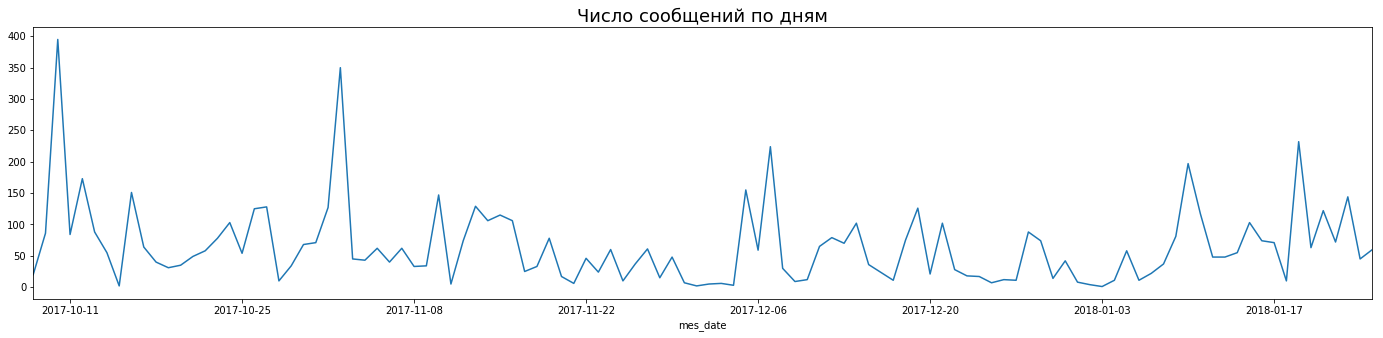

In [24]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по дням', fontsize=18)
plt.savefig('by date.png', fps=400)

### И по времени: как видим максимум неплохо коррелирует с рабочим днем:)

Пришел на работу - открыл чатик. Все правильно сделал!

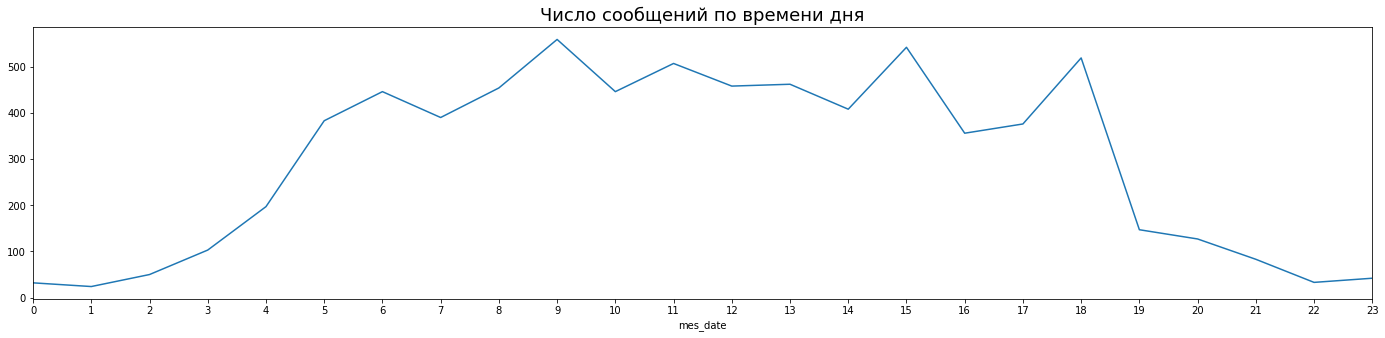

In [25]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по времени дня', fontsize=18)
plt.xticks(range(24))
plt.savefig('by hours.png', fps=400)
plt.show()

# Тематическая модель по пользователям

### Фильтрация по частям речи

In [26]:
import pymorphy2

users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']

morph = pymorphy2.MorphAnalyzer()

In [27]:
# Apro
def normalise_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)

%time users_text_norm = users_text.apply(lambda x: normalise_string(x))
users_text_norm.head()

CPU times: user 5.28 s, sys: 0 ns, total: 5.28 s
Wall time: 5.29 s


chatname
Abdikenov_Beibit()          салем весь прийти whatsup группа phd nazarbaye...
Alimbekov_Renat()           весь привет каспи банк активный восстановить l...
Amir_Miras(amirassov)       весь привет звать мираса закончить бакалавр вм...
Balgabekov_Yeldos()         ануар сразу админство плс хороший канал читаем...
Berdysh_Azamat(aberdysh)    oo mne ml kurs prepodaval kogda eshe u nas v u...
Name: text, dtype: object

In [28]:
def filter_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

%time users_text_filter = users_text.apply(lambda x: filter_string(x))
users_text_filter.head()

CPU times: user 5.66 s, sys: 20 ms, total: 5.68 s
Wall time: 5.68 s


chatname
Abdikenov_Beibit()          салем всем пришел whatsup группы phd nazarbaye...
Alimbekov_Renat()           всем привет каспи банк активен восстановить li...
Amir_Miras(amirassov)       всем привет зовут мирас закончил бакалавр вмк ...
Balgabekov_Yeldos()         ануар сразу админство плс хороший канал читаем...
Berdysh_Azamat(aberdysh)    oo mne ml kurs prepodaval kogda eshe u nas v u...
Name: text, dtype: object

### Выбор пороговых значений векторизации

Чтобы как-то выкинуть совсем уж редкие слова(аля очепятки) и совсем общеупортребительные слова

In [35]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series, min_df=0.02, max_df=0.75):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Слов в словаре: {}\n'.format(counts.shape[1]))
    print('Слова до пороговой фильтрации: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Слова у верхней границы:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Слова у нижней границы: ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        
def build_topic_subjects_report(lda, gamma, text_series, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    for topic_index in range(lda.num_topics):
        print('Topic {0} - {1}'.format(topic_index, topic_names[topic_index]))
        best_doc_indexes = gamma[:, topic_index].argsort()[-10:][::-1]
        
        subjects_with_proba = []
        for person_count, doc in enumerate(best_doc_indexes):
            if gamma[doc, topic_index] > 0.01 or person_count<3:
                subjects_with_proba.append('{0} - {1:.1%}'.format(text_series.index[doc], gamma[doc, topic_index]))
        print(', '.join(subjects_with_proba), '\n')


### Слова в начальной форме

In [33]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.05, max_df=0.95)

Слов в словаре: 3049

Слова до пороговой фильтрации:  [('курс', 265), ('дать', 193), ('topic', 157), ('такой', 150), ('который', 149), ('знать', 136), ('probability', 120), ('один', 118), ('какой', 117), ('задача', 115), ('хороший', 114), ('делать', 114), ('человек', 113), ('быть', 113), ('весь', 112), ('мочь', 109), ('год', 107), ('книга', 106), ('писать', 105), ('вообще', 105)] 

Слова у верхней границы: ['курс', 'дать', 'topic', 'такой', 'который', 'probability', 'один', 'какой', 'задача', 'хороший', 'делать', 'быть', 'человек', 'весь', 'мочь', 'год', 'книга', 'писать', 'вообще', 'тема', 'работать', 'думать', 'самый', 'data', 'сделать', 'ml', 'learning', 'хотеть', 'работа', 'поэтому', 'алгоритм', 'пока', 'свой', 'интересно', 'статья', 'понять', 'написать', 'время', 'вопрос', 'анализ']

Слова у нижней границы:  ['банка', 'внутренний', 'вовсе', 'примитивный', 'вода', 'примерный', 'применить', 'прилететь', 'вооружённый', 'приехать', 'приезжать', 'восстановить', 'вотсап', 'пригодиться',

In [42]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word, num_topics=5)

ELBO = -182881.5768, time: 10 seconds


In [43]:
build_topic_words_report(lda_norm, top_words_num=20)

0 topic: книга, который, мочь, курс, такой, ml, хороший, год, дать, думать, phd, learning, человек, писать, делать, data, весь, быть, один, theory
1 topic: курс, дать, который, задача, какой, такой, вообще, один, сделать, быть, делать, человек, год, data, книга, самый, писать, хороший, работать, весь
2 topic: topic, probability, курс, дать, такой, тема, думать, весь, хотеть, человек, хороший, вообще, писать, быть, алгоритм, один, какой, мб, делать, проходить
3 topic: работать, год, самый, один, data, мл, хотеть, matrix, shape, весь, какой, пока, интересно, опыт, начать, рахмет, чат, conditioned, ill, курс
4 topic: дать, думать, курс, такой, весь, пока, свой, решение, задача, один, какой, делать, время, команда, суббота, обезьяна, мочь, который, опыт, хороший


In [44]:
build_topic_subjects_report(lda_norm, gamma_norm, users_text_norm)

Topic 0 - 
Berdysh_Azamat(aberdysh) - 100.0%, Abdikenov_Beibit() - 100.0%, Нурышев_Нуржан() - 99.9%, Krts_Dima() - 99.9%, Panaberdiyev_Yerbol() - 99.9%, Дуйсенбаев_Азамат(azicon) - 99.8%, Makhmudov_Lecha(otrakid) - 27.9%, Z_Almaz(almaz_zinollayev) - 24.5%, _Жақсылық(zsabay) - 21.1%, Taskynov_Anuar(TaskynovAnuar) - 16.5% 

Topic 1 - 
_Ерзат Книжка(higgsfield) - 100.0%, _Adil(adilkhash) - 100.0%, Alimbekov_Renat() - 99.9%, _novitoll(novitoll) - 99.9%, _‏‏‎(rlymdk) - 99.7%, Jaraisyn_Virus(Giganotosaurus) - 98.9%, _Aktan Akhmetov() - 89.8%, Z_Almaz(almaz_zinollayev) - 75.4%, _Жақсылық(zsabay) - 72.7%, Makhmudov_Lecha(otrakid) - 72.0% 

Topic 2 - 
Sneddy_Пельмешка(cSneddy) - 100.0%, _45954(Hmmmmm123) - 99.7%, Taskynov_Anuar(TaskynovAnuar) - 55.6%, Amir_Miras(amirassov) - 38.5%, Mamrayev_Galymbek() - 29.4%, _Жақсылық(zsabay) - 6.2%, Jaraisyn_Virus(Giganotosaurus) - 1.1% 

Topic 3 - 
Balgabekov_Yeldos() - 99.9%, Maratkhan_Anuar(ardulat) - 99.9%, _45954(Hmmmmm123) - 0.1% 

Topic 4 - 
_Дархан(h

### Еще более строгий порог

In [54]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.025, max_df=0.45)
lda_norm_65, gamma_norm_65 = get_lda_model(counts, corpus_id2word, num_topics=5)

Слов в словаре: 8893

Слова до пороговой фильтрации:  [('курс', 265), ('дать', 193), ('topic', 157), ('такой', 150), ('который', 149), ('знать', 136), ('probability', 120), ('один', 118), ('какой', 117), ('задача', 115), ('хороший', 114), ('делать', 114), ('человек', 113), ('быть', 113), ('весь', 112), ('мочь', 109), ('год', 107), ('книга', 106), ('писать', 105), ('вообще', 105)] 

Слова у верхней границы: ['topic', 'probability', 'dl', 'норма', 'язык', 'типо', 'щас', 'phd', 'теория', 'том', 'rl', 'заниматься', 'питон', 'стать', 'deep', 'сетка', 'обучение', 'специализация', 'система', 'последний', 'привет', 'выйти', 'сразу', 'мб', 'брать', 'лекция', 'статистика', 'точно', 'друг', 'русский', 'далёкий', 'theory', 'идти', 'архитектура', 'программа', 'наверное', 'чат', 'дс', 'яндекс', 'сложный']

Слова у нижней границы:  ['04s', 'корректность', 'корпус', 'корпорация', 'корп', 'короткий', 'король', 'коробочный', 'корнел', 'корея', 'коррекция', 'копула', 'копипаста', 'копал', 'копа', 'конфли

In [55]:
build_topic_words_report(lda_norm_65, top_words_num=15)

0 topic: topic, probability, крч, мб, норма, дс, типо, шада, целое, конф, канал, специализация, яндекс, всякий, phd
1 topic: rl, щас, сетка, dl, theory, стать, deep, типо, архитектура, теория, последний, matrix, manifold, граф, далёкий
2 topic: язык, программа, питон, том, наверное, точно, phd, норма, примерно, система, dl, теория, друг, автор, специализация
3 topic: евро, язык, ранний, code, готовый, версия, изучать, шутка, зависеть, нравиться, казахстан, pandas, пробовать, rstudio, numpy
4 topic: phd, привет, суббота, выборка, том, товар, статистика, сайт, интересовать, kaggle, клиент, архитектура, spark, подсказать, real


In [56]:
build_topic_subjects_report(lda_norm_65, gamma_norm_65, users_text_norm)

Topic 0 - 
Sneddy_Пельмешка(cSneddy) - 100.0%, Taskynov_Anuar(TaskynovAnuar) - 100.0%, _Дархан(hoogleraar) - 99.9%, Krts_Dima() - 99.9%, Jaraisyn_Virus(Giganotosaurus) - 99.9%, Panaberdiyev_Yerbol() - 99.9%, Дуйсенбаев_Азамат(azicon) - 99.8%, _Sagimbayev Zhuldyzzhan(cruigo93) - 99.8%, _‏‏‎(rlymdk) - 99.7% 

Topic 1 - 
_Ерзат Книжка(higgsfield) - 100.0%, Berdysh_Azamat(aberdysh) - 100.0%, Balgabekov_Yeldos() - 99.9%, Maratkhan_Anuar(ardulat) - 99.9%, Z_Almaz(almaz_zinollayev) - 99.9%, _Мухаммад(grizzly_puma) - 99.9%, Makhmudov_Lecha(otrakid) - 99.8% 

Topic 2 - 
_Aktan Akhmetov() - 100.0%, _Adil(adilkhash) - 100.0%, Abdikenov_Beibit() - 100.0%, _novitoll(novitoll) - 99.9%, Alimbekov_Renat() - 99.9%, Mamrayev_Galymbek() - 99.9%, Amir_Miras(amirassov) - 99.8% 

Topic 3 - 
_Жақсылық(zsabay) - 99.9%, _45954(Hmmmmm123) - 0.1%, _‏‏‎(rlymdk) - 0.1% 

Topic 4 - 
Нурышев_Нуржан() - 99.9%, Raimkulov_Azat(AzatRZ) - 99.9%, _TMT() - 99.9%, _45954(Hmmmmm123) - 99.7% 



### В Свободной форме

In [84]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.04, max_df=0.95)

Слов в словаре: 3685

Слова до пороговой фильтрации:  [('topic', 157), ('probability', 120), ('курс', 115), ('данных', 114), ('вообще', 105), ('data', 88), ('ml', 86), ('learning', 84), ('поэтому', 74), ('пока', 71), ('интересно', 69), ('которые', 65), ('всем', 64), ('думаю', 63), ('знаю', 63), ('r', 57), ('какие', 55), ('такое', 53), ('python', 53), ('ds', 51)] 

Слова у верхней границы: ['topic', 'probability', 'курс', 'данных', 'вообще', 'data', 'ml', 'learning', 'поэтому', 'пока', 'интересно', 'которые', 'всем', 'думаю', 'знаю', 'какие', 'такое', 'python', 'ds', 'dl', 'курсы', 'понял', 'курса', 'круто', 'типо', 'щас', 'phd', 'мл', 'норм', 'тема', 'книга', 'могу', 'будут', 'кз', 'данные', 'rl', 'делать', 'deep', 'сделать', 'время']

Слова у нижней границы:  ['определится', 'выбора', 'выбор', 'выбирать', 'небольших', 'входе', 'небольшое', 'вузов', 'вуззи', 'выборе', 'самостоятельные', 'самостоятельно', 'телефон', 'телефоном', 'всякое', 'теллурид', 'всякими', 'сайнтисты', 'незаменимы'

In [85]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.04, max_df=0.35)

Слов в словаре: 3552

Слова до пороговой фильтрации:  [('topic', 157), ('probability', 120), ('курс', 115), ('данных', 114), ('вообще', 105), ('data', 88), ('ml', 86), ('learning', 84), ('поэтому', 74), ('пока', 71), ('интересно', 69), ('которые', 65), ('всем', 64), ('думаю', 63), ('знаю', 63), ('r', 57), ('какие', 55), ('такое', 53), ('python', 53), ('ds', 51)] 

Слова у верхней границы: ['topic', 'probability', 'dl', 'щас', 'типо', 'норм', 'rl', 'deep', 'мб', 'theory', 'анализа', 'задач', 'дс', 'дальше', 'etc', 'книги', 'na', 'алгоритмы', 'хз', 'примерно', 'понятно', 'целом', 'общем', 'методы', 'matrix', 'года', 'проходил', 'всё', 'этих', 'теории', 'лекции', 'лол', 'делал', 'самое', 'свой', 'модель', 'введение', 'мгу', 'ai', 'получается']

Слова у нижней границы:  ['машинного', 'прямой', 'публикации', 'публикуют', 'задавать', 'загнать', 'загадочный', 'завтра', 'заводим', 'пустили', 'завершения', 'пытаться', 'пыхеры', 'забавно', 'жрет', 'пятницы', 'живого', 'работало', 'жестко', 'рабо

In [86]:
lda, gamma = get_lda_model(counts, corpus_id2word, num_topics=5)

ELBO = -135954.6154, time: 14 seconds


In [87]:
build_topic_words_report(lda, top_words_num=15)

0 topic: theory, manifold, matrix, na, etc, number, function, linear, space, non, optimization, салем, paper, probability, книги
1 topic: щас, dl, rl, типо, deep, норм, дальше, получается, понятно, gpu, статьи, питоне, nlp, задач, несколько
2 topic: topic, probability, дс, типо, мб, прост, общем, алгоритмы, норм, канал, астана, анализа, целом, проходил, идее
3 topic: мгу, норм, лол, методы, можешь, шаде, мб, задач, идет, проходил, воронцова, целом, байес, хз, темы
4 topic: всё, spark, ai, специализации, больших, анализа, big, мфти, learn, na, насколько, лекции, pandas, hadoop, машин


In [88]:
build_topic_subjects_report(lda, gamma, users_text_filter)

Topic 0 - 
Berdysh_Azamat(aberdysh) - 100.0%, Abdikenov_Beibit() - 99.9%, Balgabekov_Yeldos() - 99.9%, Alimbekov_Renat() - 99.9%, Makhmudov_Lecha(otrakid) - 23.9% 

Topic 1 - 
_Ерзат Книжка(higgsfield) - 100.0%, _Aktan Akhmetov() - 100.0%, _novitoll(novitoll) - 99.9%, Нурышев_Нуржан() - 99.9%, Krts_Dima() - 99.9%, Jaraisyn_Virus(Giganotosaurus) - 99.9%, Raimkulov_Azat(AzatRZ) - 99.8%, _Жақсылық(zsabay) - 99.8%, _‏‏‎(rlymdk) - 99.6% 

Topic 2 - 
Sneddy_Пельмешка(cSneddy) - 100.0%, Mamrayev_Galymbek() - 99.8%, Maratkhan_Anuar(ardulat) - 99.8%, _Мухаммад(grizzly_puma) - 99.8%, _TMT() - 99.8%, _Sagimbayev Zhuldyzzhan(cruigo93) - 99.7%, _45954(Hmmmmm123) - 99.5%, Makhmudov_Lecha(otrakid) - 26.7% 

Topic 3 - 
Taskynov_Anuar(TaskynovAnuar) - 99.9%, _Дархан(hoogleraar) - 99.9%, Z_Almaz(almaz_zinollayev) - 99.8%, Amir_Miras(amirassov) - 99.8%, Дуйсенбаев_Азамат(azicon) - 99.8%, Makhmudov_Lecha(otrakid) - 49.3% 

Topic 4 - 
_Adil(adilkhash) - 100.0%, Panaberdiyev_Yerbol() - 99.8%, _45954(Hmmmmm1

## Тематическая модель по неделям

In [90]:
week_text = corpus.groupby(corpus.mes_date.apply(lambda x: '{1}-{0}'.format(x.week, x.year))).agg(lambda x: ' '.join(x))['text']
print(week_text.shape)
week_text.head()

(17,)


mes_date
2017-40    ануар сразу админство плс крч всем привет созд...
2017-41    учителя востребованы раньше coursera помогаем ...
2017-42    общем правило представляться вновь прибывшим б...
2017-43    советую ознакомиться kafka kafka streaming api...
2017-44    продолжению треду information bottleneck numer...
Name: text, dtype: object

In [91]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_filter = week_text.apply(lambda x: filter_string(x))
week_text_filter.head()

CPU times: user 8.28 s, sys: 4 ms, total: 8.29 s
Wall time: 8.29 s


mes_date
2017-40    ануар сразу админство плс крч всем привет созд...
2017-41    учителя востребованы раньше coursera помогаем ...
2017-42    общем правило представляться вновь прибывшим б...
2017-43    советую ознакомиться kafka kafka streaming api...
2017-44    продолжению треду information bottleneck numer...
Name: text, dtype: object

In [103]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_filter, min_df=0.06, max_df=0.55)

Слов в словаре: 4820

Слова до пороговой фильтрации:  [('data', 175), ('всем', 167), ('данных', 162), ('ml', 162), ('topic', 158), ('курс', 150), ('вообще', 132), ('hello', 125), ('learning', 124), ('привет', 122), ('probability', 120), ('пока', 110), ('интересно', 108), ('думаю', 96), ('python', 96), ('ds', 93), ('которые', 85), ('поэтому', 85), ('r', 83), ('знаю', 82)] 

Слова у верхней границы: ['probability', 'theory', 'кбту', 'книги', 'методы', 'spark', 'matrix', 'знание', 'давайте', 'computer', 'big', 'посмотреть', 'решения', 'модели', 'like', 'меньше', 'manifold', 'ребят', 'виду', 'студентов', 'введение', 'математика', 'новым', 'слова', 'зп', 'нужны', 'тд', 'ne', 'читать', 'сути', 'engineer', 'уровень', 'годом', 'linear', 'мфти', 'уровне', 'давно', 'выше', 'optimization', 'хайп']

Слова у нижней границы:  ['өзіңді', 'доказательств', 'доказанное', 'дока', 'дождаться', 'догнали', 'догнал', 'размеры', 'разный', 'добрая', 'разрабами', 'добавляет', 'разрабатывает', 'разрабов', 'добав

In [104]:
lda_week, gamma_week = get_lda_model(counts, corpus_id2word, num_topics=5)

ELBO = -191802.8598, time: 15 seconds


In [105]:
build_topic_words_report(lda_week, top_words_num=15)

0 topic: методы, manifold, matrix, theory, np, optimization, spark, based, like, знание, обзор, введение, опыта, pca, number
1 topic: решения, годом, новым, кбту, big, посмотреть, computer, книги, spark, vision, ребят, прошел, тест, сетка, tsp
2 topic: probability, зп, theory, модели, программа, проекты, хайп, уровне, знание, язык, control, computer, mit, программы, идее
3 topic: читать, good, мат, thanks, стажировку, приложение, книги, математика, требования, oracle, мощность, списка, веса, yahoo, питон
4 topic: probability, theory, решения, number, методы, давно, manifold, мфти, уровень, читать, знание, matrix, имеет, linear, опыта


In [106]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_filter)
topic_dynamic['topic'] = np.argmax(gamma_week, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-40,ануар сразу админство плс крч всем привет созд...,2,730,2017-10-02
2017-41,учителя востребованы раньше coursera помогаем ...,1,37674,2017-10-09
2017-42,общем правило представляться вновь прибывшим б...,0,30056,2017-10-16
2017-43,советую ознакомиться kafka kafka streaming api...,2,24609,2017-10-23
2017-44,продолжению треду information bottleneck numer...,0,40993,2017-10-30


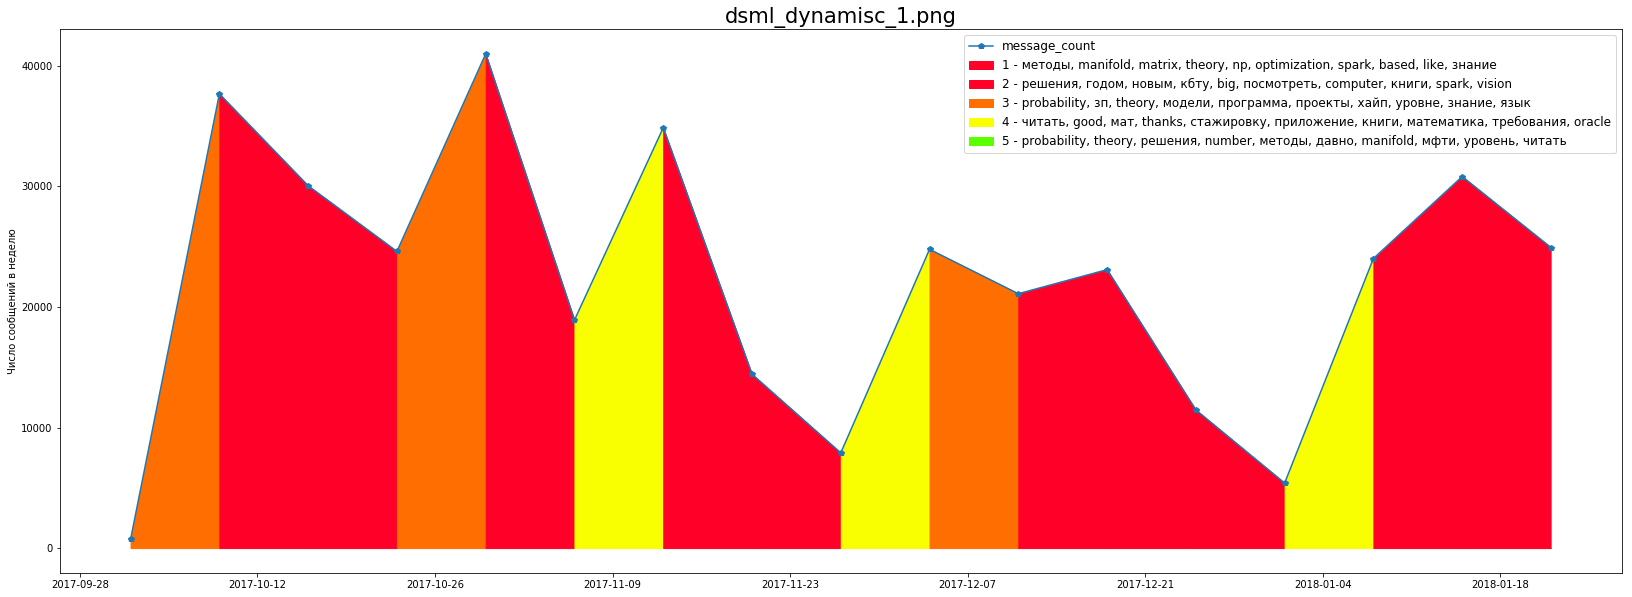

In [109]:
import matplotlib as mpl
cmap = mpl.cm.gist_rainbow
normalize = mpl.colors.Normalize(vmin=1, vmax=10)
cmap(normalize(3))

plt.figure(figsize=(28,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(lda_week.num_topics):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylabel('Число сообщений в неделю')
plt.title('dsml_dynamisc_1.png', fontsize=21)
plt.savefig('topic_history.png')
plt.show()

### Та же модель с приведением к нормальной форме

In [110]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_norm = week_text.apply(lambda x: normalise_string(x))
week_text_norm.head()

CPU times: user 9.39 s, sys: 12 ms, total: 9.4 s
Wall time: 9.41 s


mes_date
2017-40    ануар сразу админство плс крч весь привет созд...
2017-41    учитель востребовать ранний coursera помогать ...
2017-42    общий правило представляться вновь прибыть бук...
2017-43    советовать ознакомиться kafka kafka streaming ...
2017-44    продолжение тред information bottleneck numeri...
Name: text, dtype: object

In [124]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.1, max_df=0.7)

Слов в словаре: 3815

Слова до пороговой фильтрации:  [('курс', 351), ('дать', 284), ('весь', 238), ('такой', 203), ('который', 194), ('работать', 186), ('знать', 178), ('год', 177), ('data', 175), ('задача', 172), ('быть', 167), ('мочь', 163), ('человек', 162), ('делать', 162), ('ml', 162), ('какой', 158), ('topic', 158), ('хороший', 157), ('один', 157), ('думать', 145)] 

Слова у верхней границы: ['probability', 'rl', 'щас', 'онлайн', 'сетка', 'далёкий', 'бизнес', 'решать', 'специализация', 'сложный', 'добрый', 'лекция', 'theory', 'материал', 'русский', 'задание', 'архитектура', 'сам', 'тест', 'митапа', 'месяц', 'шада', 'na', 'яндекс', 'gpu', 'небольшой', 'учить', 'готовый', 'автор', 'мгу', 'вариант', 'практика', 'видео', 'google', 'датасет', 'полный', 'spark', 'nlp', 'кбт', 'текст']

Слова у нижней границы:  ['өзіңді', 'прилететь', 'приличный', 'примерный', 'примитивный', 'приоритет', 'баейс', 'природа', 'бабла', 'прирост', 'ахи', 'прислать', 'африка', 'аутсорсить', 'аутсорс', 'прис

In [125]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)

ELBO = -188534.2747, time: 17 seconds


In [126]:
build_topic_words_report(lda_week_norm, top_words_num=15)

0 topic: np, optimization, non, обзор, convex, hard, автор, intelligence, труд, отчёт, почитать, analysis, спросить, полный, kaggle
1 topic: сетка, специализация, зп, хакатон, бот, слой, чувак, хайп, gpu, big, функция, neural, щас, небольшой, яндекс
2 topic: probability, google, rl, приложение, видео, чатик, сервер, список, книжка, gpu, москва, выборка, мощность, good, стажировка
3 topic: байес, граф, матрица, theory, pca, тф, mcmc, организация, bayesian, щас, градиент, information, лассо, фич, based
4 topic: суббота, встреча, вариант, добрый, шада, онлайн, scientist, вуз, кбт, митапа, мгу, салем, девушка, ата, конец
5 topic: rl, прокуратура, manifold, na, игра, щас, решать, matrix, архитектура, сложный, клиент, онлайн, материал, theory, база
6 topic: probability, щас, бизнес, специализация, материал, big, лекция, практический, бот, rl, уметь, месяц, задание, добрый, google
7 topic: онлайн, картинка, сетка, ошибка, рынок, задание, мфть, обезьяна, тест, специализация, shape, pandas, при

In [190]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-40,ануар сразу админство плс крч весь привет созд...,4,730,2017-10-02
2017-41,учитель востребовать ранний coursera помогать ...,4,37674,2017-10-09
2017-42,общий правило представляться вновь прибыть бук...,5,30056,2017-10-16
2017-43,советовать ознакомиться kafka kafka streaming ...,1,24609,2017-10-23
2017-44,продолжение тред information bottleneck numeri...,3,40993,2017-10-30


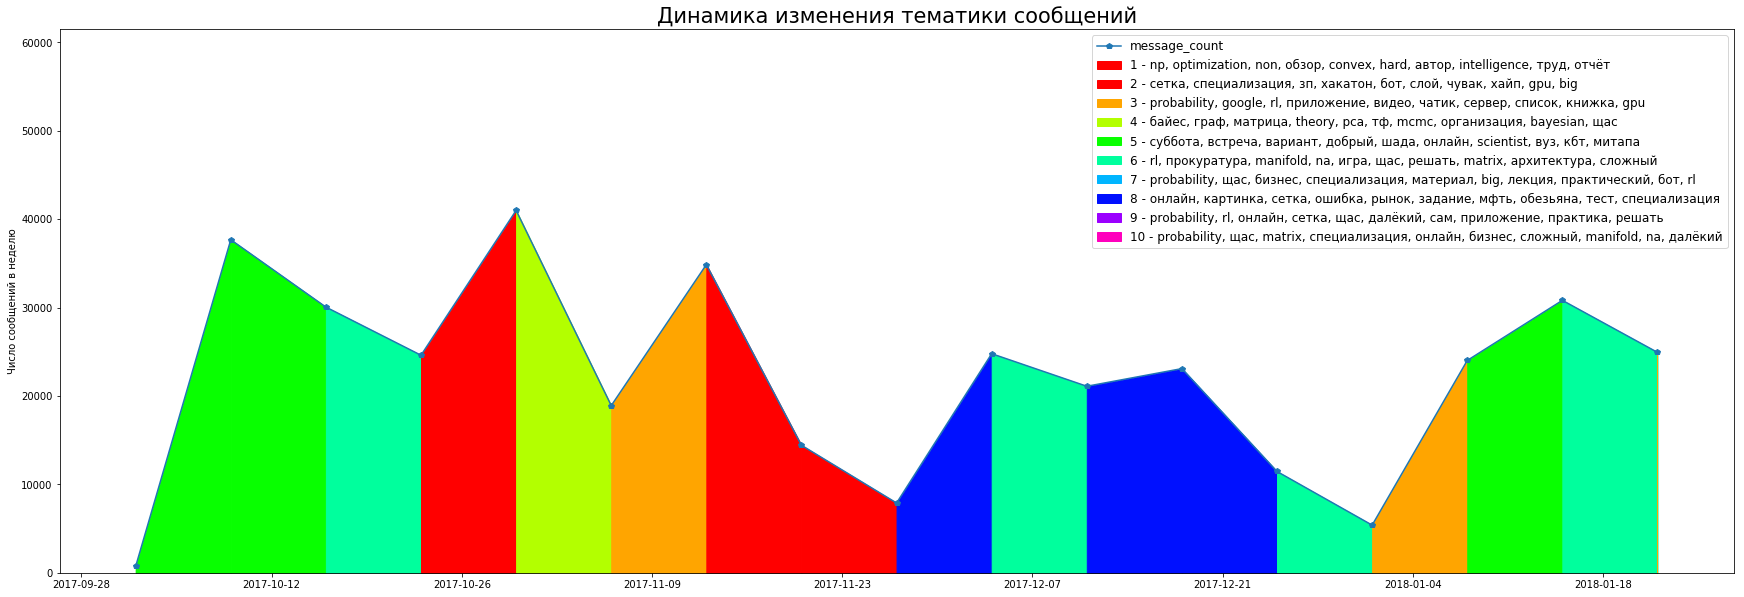

In [191]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений', fontsize=21)
plt.savefig('dsml_dynamic_norm.png')
plt.show()

## Та же модель по дням

In [159]:
day_text = corpus.groupby(corpus.mes_date.dt.date).agg(lambda x: ' '.join(x))['text']
print(day_text.shape)
day_text.head()

(109,)


mes_date
2017-10-08    ануар сразу админство плс крч всем привет созд...
2017-10-09    учителя востребованы раньше coursera помогаем ...
2017-10-10    вроде отдельно ребят связи постами выше хотело...
2017-10-11    доброе утро астане вообще проживает тому собра...
2017-10-12    вкусы весьма специфичны import xgbregressor kn...
Name: text, dtype: object

In [160]:
morph = pymorphy2.MorphAnalyzer()
%time day_text_norm = day_text.apply(lambda x: normalise_string(x))
day_text_norm.head()

CPU times: user 8.43 s, sys: 4 ms, total: 8.44 s
Wall time: 8.44 s


mes_date
2017-10-08    ануар сразу админство плс крч весь привет созд...
2017-10-09    учитель востребовать ранний coursera помогать ...
2017-10-10    отдельно ребята связь пост выше хотеться поинт...
2017-10-11    добрый утро астан вообще проживать тот собрать...
2017-10-12    вкус весьма специфичный import xgbregressor kn...
Name: text, dtype: object

In [184]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.25)

Слов в словаре: 4087

Слова до пороговой фильтрации:  [('курс', 351), ('дать', 284), ('весь', 238), ('такой', 203), ('который', 194), ('работать', 186), ('знать', 178), ('год', 177), ('data', 175), ('задача', 172), ('быть', 167), ('мочь', 163), ('человек', 162), ('делать', 162), ('ml', 162), ('какой', 158), ('topic', 158), ('хороший', 157), ('один', 157), ('думать', 145)] 

Слова у верхней границы: ['topic', 'probability', 'phd', 'студент', 'dl', 'питон', 'аналитик', 'уровень', 'rl', 'программа', 'щас', 'онлайн', 'типо', 'ai', 'ануар', 'смысл', 'неделя', 'статистика', 'посмотреть', 'мб', 'друг', 'разработка', 'программирование', 'сетка', 'пройти', 'бизнес', 'идти', 'специализация', 'выйти', 'математика', 'гугл', 'решать', 'добрый', 'часть', 'целое', 'решить', 'сложный', 'машинный', 'взять', 'дс']

Слова у нижней границы:  ['өзіңді', 'свобода', 'ооо', 'sufficient', 'оо', 'олжас', 'studying', 'дружелюбный', 'связаться', 'stuck', 'окружающий', 'stronger', 'street', 'душа', 'дъяконов', 'st

In [185]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)

ELBO = -218530.3653, time: 26 seconds


In [186]:
build_topic_words_report(lda_day_norm, top_words_num=15)

0 topic: байес, граф, pca, типо, тф, mcmc, запрос, получаться, выйти, фич, градиент, матрица, дерево, организация, лассо
1 topic: matrix, number, евро, бот, казахстан, квантовый, see, elements, ill, conditioned, дс, рынок, ai, существовать, large
2 topic: слой, сетка, тест, tsp, пройти, случай, линейный, бизнес, часть, решать, немного, time, highway, транспортный, target
3 topic: phd, студент, экономика, качество, байес, школа, программист, универ, машинный, поступить, статистика, штука, мастерс, взять, scientist
4 topic: manifold, nlp, space, smooth, выборка, ия, width, depth, клиент, матрица, панель, подсказать, advanced, лекция, щас
5 topic: программа, прокуратура, платить, аналитик, уровень, зп, страна, алгебра, автор, смысл, сам, возможность, нормальный, образование, собеседование
6 topic: spark, специализация, big, хакатон, щас, небольшой, лекция, месяц, инструмент, хайп, бизнес, часть, сетка, архитектура, вектор
7 topic: rl, питон, ai, митапа, phd, всякий, гугл, разработчик, тех

In [187]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-10-08,ануар сразу админство плс крч весь привет созд...,7,730,2017-10-08
2017-10-09,учитель востребовать ранний coursera помогать ...,4,3777,2017-10-09
2017-10-10,отдельно ребята связь пост выше хотеться поинт...,5,16767,2017-10-10
2017-10-11,добрый утро астан вообще проживать тот собрать...,7,4595,2017-10-11
2017-10-12,вкус весьма специфичный import xgbregressor kn...,7,6502,2017-10-12


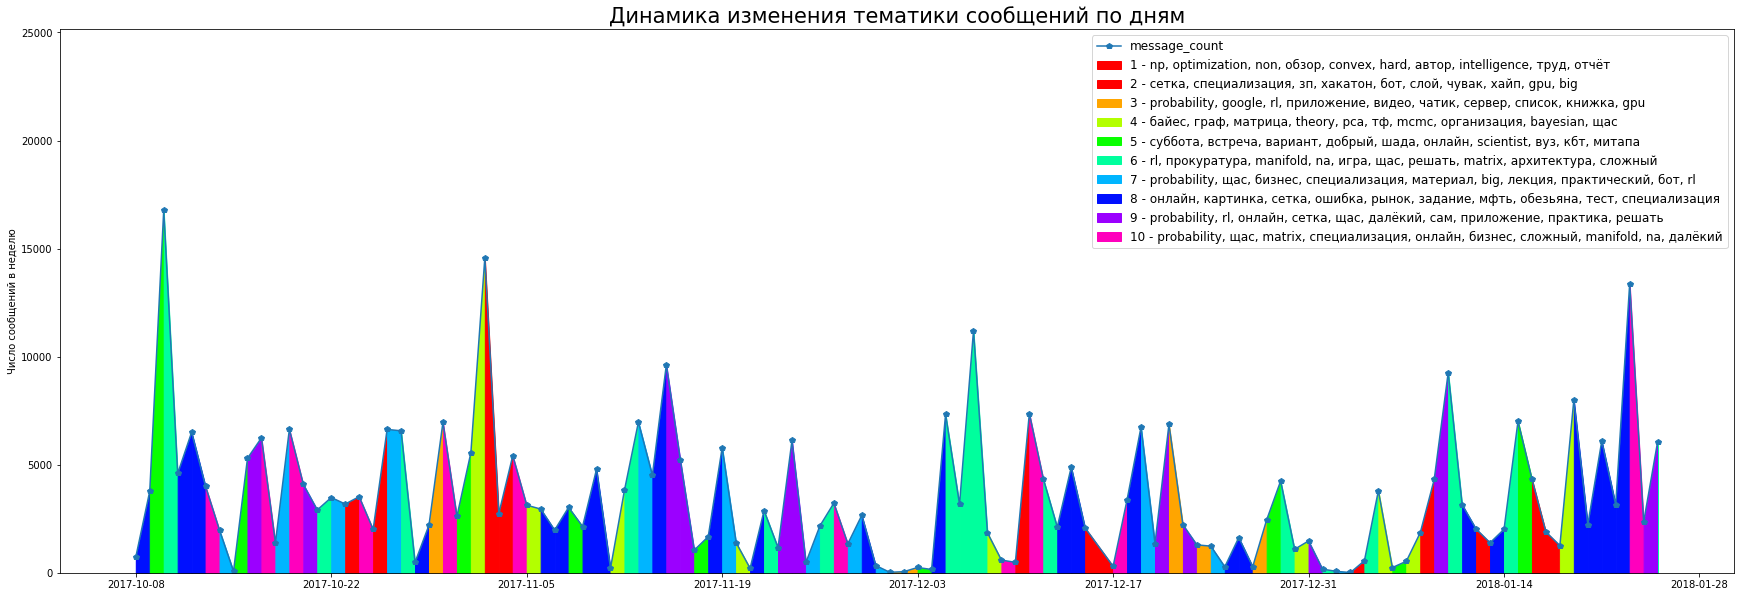

In [189]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики сообщений по дням', fontsize=21)
plt.savefig('dsml_day_dynamic_norm.png')
plt.show()